In [109]:
import datetime
print(datetime.datetime.now())

2023-07-20 07:14:39.785019


In [110]:
# Supress scikit-learn's deprecations warnings.

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [111]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import itertools
import scipy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Prepare the data

In [112]:
greeks = pd.read_csv("../icr-identify-age-related-conditions/greeks.csv")
test = pd.read_csv("../icr-identify-age-related-conditions/test.csv")
train = pd.read_csv("../icr-identify-age-related-conditions/train.csv")
# data = pd.merge(train, greeks[['Id', 'Alpha']], on='Id', how='left') # Merge the train and greek data

Alpha Identifies the type of age-related condition, if present.
* A No age-related condition. Corresponds to class 0.
* B, D, G The three age-related conditions. Correspond to class 1.
Beta, Gamma, Delta Three experimental characteristics.

Epsilon The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.

In [113]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


* Id Unique identifier for each observation.
* AB-GL Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical.
* Class A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.

In [114]:
#identify columns with NAs and the number of NAs
train.isnull().sum()

Id        0
AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

## Clean the Data

In [115]:
train = train.drop(['EJ'], axis=1)
test = test.drop(['EJ'], axis=1)

train = train.rename(columns={'BD ': 'BD', 'CD ': 'CD', 'CW ': 'CW', 'FD ': 'FD'})
test = test.rename(columns={'BD ': 'BD', 'CD ': 'CD', 'CW ': 'CW', 'FD ': 'FD'})

print(f'df_train shape: {train.shape}\n')
print(f'df_test shape: {test.shape}\n')

df_train shape: (617, 57)

df_test shape: (5, 56)



## Handle Missing Data
Fulfill the missing data with the mean value

In [116]:
# Select the features and target
features_numerical  = [column for column in train.columns if column not in ['Id', 'Class', 'Alpha']]
target = 'Class'

# Prepare the data - encode, remove inf, -inf and fill NaNs
for column in train.columns:
    if train[column].dtype == 'object':
        train[column] = train[column].astype('category').cat.codes

for column in features_numerical:
    train[column] = train[column].replace([np.inf, -np.inf], np.nan)
    train[column] = train[column].fillna(train[column].mean())

train.columns[train.isnull().any()].tolist()
train.info()

[]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    int16  
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      617 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      617 non-null    float64
 17  CC      617 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

## Find and remove outliers of health characteristics

In [117]:
# Visualize the data in line chart
feature_names = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BN', 'BQ', 'BR', 'BZ', 'CB', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EP', 'EU', 'FE', 'FI', 'FR', 'GB', 'GE', 'GF', 'GH', 'GI']
# feature_names = ['AB']

def lineChart(feature_name):
    feature_data = train[feature_name].to_numpy()
    plt.plot(feature_data)
    plt.show()

# remove the outliers using IQR logic
def removeOutliers(feature_data):
    # print(feature_data)
    mean = np.mean(feature_data)
    print(mean)
    q1, q3 = np.percentile(feature_data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = [x for x in feature_data if x < lower_bound or x > upper_bound]
    feature_data_replaced = [mean if x < lower_bound or x > upper_bound else x for x in feature_data]
    print("The count of outliers are:", len(outliers))
    # print("The data with replaced outliers is:", feature_data_replaced)
    return feature_data_replaced

for feature_name in feature_names:
    # lineChart(feature_name)
    feature_data = train[feature_name]
    feature_data_new = removeOutliers(feature_data)
    # print(len(feature_data), len(feature_data_new))
    train[feature_name] = feature_data_new

0.477149358184765
The count of outliers are: 35
3502.0132207455435
The count of outliers are: 19
118.62451267179904
The count of outliers are: 70
38.96855212965964
The count of outliers are: 54
10.12824205186386
The count of outliers are: 133
5.545576059967586
The count of outliers are: 27
0.06031962398703402
The count of outliers are: 107
10.566446961102107
The count of outliers are: 14
8.053011588330632
The count of outliers are: 45
21.419492382495946
The count of outliers are: 14
98.32873688509875
The count of outliers are: 58
1218.133237713128
The count of outliers are: 47
550.6325253525121
The count of outliers are: 116
77.10415084878048
The count of outliers are: 47
11.241063893030795
The count of outliers are: 38
0.030614714748784445
The count of outliers are: 30
1.4037610332252837
The count of outliers are: 74
0.7422616288492706
The count of outliers are: 31
36.91758957131281
The count of outliers are: 31
1.3837923598055106
The count of outliers are: 21
51.128325834683956
The c

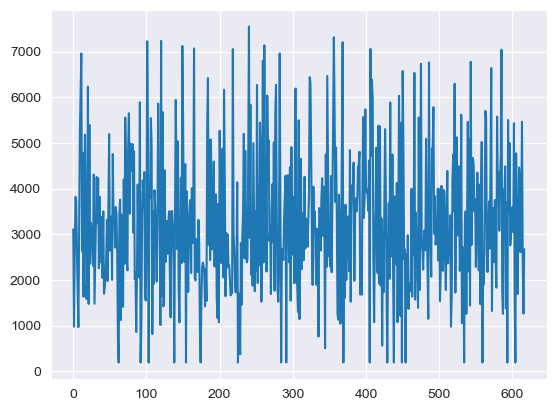

In [118]:
# visualization of the data after removing outlier
plt.plot(train['AF'])
plt.show()

At this stage: missing value was fulfilled with mean of each column and outlier was also removed. Column name was updated to remove the space. Unnecessary column was removed: EJ

## Feature Scaling

In [119]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    int16  
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      617 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      617 non-null    float64
 17  CC      617 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [ ]:
from sklearn.preprocessing import StandardScaler
# get feature data
features = train.drop(columns=["Id", "Class"], axis=1)
target = train['Class']

In [123]:
# Scale the values using standard scaler
scaler = StandardScaler()
scaler.fit(features)
X_scaled = scaler.transform(features)
X_scaled

StandardScaler()

array([[-0.98324512, -0.09363553, -0.64807134, ..., -1.01098094,
         0.76211309, -0.81575237],
       [-1.3143286 , -1.48253018, -0.64807134, ..., -0.19891381,
        -0.49273965,  1.30423877],
       [ 0.36316104, -0.40262669, -0.64807134, ..., -0.32799838,
        -0.39087222, -0.80832304],
       ...,
       [ 0.14243872, -0.51737489,  1.82471227, ..., -0.54342714,
         2.41707373,  1.30423877],
       [-0.18864476, -1.29686489, -0.64807134, ..., -0.66517245,
        -0.32555721, -0.80951792],
       [ 0.42937773, -0.37822453,  1.19113856, ...,  1.72828856,
         2.26007804,  1.30423877]])

(617, 46)

ValueError: Unknown label type: 'continuous-multioutput'